In [1]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt

import torch
import torch_geometric
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric import nn as gnn

from graph_vae import GraphVAE
from train import train_loop2
from data_load import *

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

## Scratchpad

In [6]:
d = torch.randn(10)
d_diag = torch.diag_embed(d)
M = torch.randn(10, 10)

print(torch.all(d.unsqueeze(1)*M == torch.matmul(d_diag, M)))
print(torch.all(M * d == torch.matmul(M, d_diag)))

tensor(True)
tensor(True)


In [6]:
dataset = get_train_dataset()
data_loader = torch.utils.data.DataLoader(dataset, 200, True)

In [18]:
for (X, NL, mask) in data_loader:
    A = eval_A(NL.int())*mask.unsqueeze(2)
    print(X[:, :, -1].max())

tensor(0.8951)
tensor(0.9118)
tensor(0.9004)
tensor(0.8894)
tensor(0.8476)
tensor(0.9631)
tensor(0.8371)
tensor(1.0133)
tensor(0.8952)
tensor(0.9213)
tensor(0.8329)
tensor(0.8558)
tensor(0.9442)
tensor(0.8626)
tensor(0.8884)
tensor(0.9379)
tensor(0.8939)
tensor(0.8558)
tensor(1.1926)
tensor(0.9205)
tensor(0.9311)
tensor(0.8475)
tensor(0.9733)
tensor(1.0340)
tensor(0.8867)
tensor(0.8736)
tensor(0.8699)
tensor(0.9059)
tensor(0.9021)
tensor(0.8803)
tensor(0.8987)
tensor(0.9044)
tensor(1.0155)
tensor(0.9302)
tensor(0.9912)
tensor(1.0871)
tensor(0.9920)
tensor(0.9254)
tensor(0.9718)
tensor(0.9681)
tensor(0.9595)
tensor(0.9228)
tensor(0.8817)
tensor(0.8920)
tensor(0.9043)
tensor(1.0227)
tensor(0.9477)
tensor(0.8980)
tensor(1.2631)
tensor(0.9206)
tensor(0.8822)
tensor(0.8873)
tensor(0.8166)
tensor(0.8116)
tensor(0.9536)
tensor(1.2312)
tensor(0.8409)
tensor(0.9117)
tensor(0.8505)
tensor(0.9070)
tensor(0.9140)
tensor(0.8872)
tensor(0.8432)
tensor(0.9075)
tensor(0.9113)
tensor(0.8508)
tensor(1.0

In [10]:
? torch.min

Docstring:
min(input) -> Tensor

Returns the minimum value of all elements in the :attr:`input` tensor.

.. warning::
    This function produces deterministic (sub)gradients unlike ``min(dim=0)``

Args:
    input (Tensor): the input tensor.

Example::

    >>> a = torch.randn(1, 3)
    >>> a
    tensor([[ 0.6750,  1.0857,  1.7197]])
    >>> torch.min(a)
    tensor(0.6750)

.. function:: min(input, dim, keepdim=False, *, out=None) -> (Tensor, LongTensor)
   :noindex:

Returns a namedtuple ``(values, indices)`` where ``values`` is the minimum
value of each row of the :attr:`input` tensor in the given dimension
:attr:`dim`. And ``indices`` is the index location of each minimum value found
(argmin).

If :attr:`keepdim` is ``True``, the output tensors are of the same size as
:attr:`input` except in the dimension :attr:`dim` where they are of size 1.
Otherwise, :attr:`dim` is squeezed (see :func:`torch.squeeze`), resulting in
the output tensors having 1 fewer dimension than :attr:`input`.

.

## Model Definition and training

In [3]:
net = GraphVAE(400, 3)
# net.load_state_dict(torch.load("Saves/ecal_ep_60.pth"))

In [6]:
train_loop2(net, 20, 200, 5e-4, device)

Epoch : 1 Loss: 0.00977 E mse: 0.03432 Hit mse: 0.00997 L2: 2.58384
Epoch : 2 Loss: 0.00569 E mse: 0.03432 Hit mse: 0.00997 L2: 2.58381
Epoch : 3 Loss: 0.00438 E mse: 0.03432 Hit mse: 0.00997 L2: 2.58380
Epoch : 4 Loss: 0.00445 E mse: 0.03432 Hit mse: 0.00997 L2: 2.58379
Epoch : 5 Loss: 0.00349 E mse: 0.03432 Hit mse: 0.00997 L2: 2.58379
Epoch : 6 Loss: 0.00425 E mse: 0.03432 Hit mse: 0.00997 L2: 2.58380
Epoch : 7 Loss: 0.00650 E mse: 0.03432 Hit mse: 0.00997 L2: 2.58381
Epoch : 8 Loss: 0.00299 E mse: 0.03432 Hit mse: 0.00997 L2: 2.58379
Epoch : 9 Loss: 0.00486 E mse: 0.03432 Hit mse: 0.00997 L2: 2.58380
Epoch : 10 Loss: 0.00344 E mse: 0.03432 Hit mse: 0.00997 L2: 2.58378
Epoch : 11 Loss: 0.00007 E mse: 0.03432 Hit mse: 0.00997 L2: 2.58376
Epoch : 12 Loss: 0.00272 E mse: 0.03432 Hit mse: 0.00998 L2: 2.58379
Epoch : 13 Loss: 0.00329 E mse: 0.03432 Hit mse: 0.00997 L2: 2.58379
Epoch : 14 Loss: 0.00296 E mse: 0.03432 Hit mse: 0.00997 L2: 2.58379
Epoch : 15 Loss: 0.00567 E mse: 0.03432 Hit

In [7]:
torch.save(net.state_dict(), "Saves/ecal_ep_60.pth")

tensor(0.0100)

## Inference and tests

In [8]:
def reconstruct_img3(Y, mask):
    xhit, yhit = Y[:, :, 0], Y[:, :, 1]
    val = Y[:, :, 2]/50.
    
    xhit = (xhit % 125).int()
    yhit = (yhit % 125).int()
    
    mask = mask*torch.arange(1, 0, -1./400)**2
    # mask = mask*torch.exp(-torch.arange(400))
    ecal = torch.zeros((Y.shape[0], 125, 125))
    ecal[
        torch.arange(Y.shape[0]).unsqueeze(1),
        xhit,
        yhit
    ] = mask #*val
    
    return ecal

def reconstruct_img2(Y, mask):
    xhit, yhit = (Y[:, :, 0])*125, (Y[:, :, 1])*125
    ener = ((Y[:, :, 2] + 10))**5
    
    xhit = (xhit % 125).int()
    yhit = (yhit % 125).int()
    
    ecal = torch.zeros((Y.shape[0], 125, 125))
    ecal[
        torch.arange(Y.shape[0]).unsqueeze(1),
        xhit,
        yhit
    ] = mask*ener
    
    return ecal

def loss_infer2(net, X, A, mask):
    """
    Inference loss function
    """
    # Reconstructed nodes and edges
    Y, A2, mu, logvar, L1, L2 = net(X, A, mask)
    # Convert back to image
    ecal = reconstruct_img2(Y, mask)
    
    mse = torch.nn.MSELoss()
    return mse(X, Y), ecal, A2

In [4]:
net = GraphVAE(400, 3)
net.load_state_dict(torch.load("Saves/ecal_ep_60.pth"))

<All keys matched successfully>

In [9]:
dataset = get_train_dataset()
data_loader = torch.utils.data.DataLoader(dataset, 200, True)

In [10]:
for (X, NL, mask) in data_loader:
    X = X
    A = eval_A(NL.int()) * mask.unsqueeze(2)
    mask = mask
    with torch.no_grad():
        # Original samples
        img1 = reconstruct_img2(X, mask)
        # VAE-generated samples
        L, img2, A2 = loss_infer2(net, X, A, mask)
    break

In [11]:
img1.max(), img1.min()

(tensor(153270.7500), tensor(0.))

In [12]:
img2.max(), img2.min()

(tensor(100000.), tensor(0.))

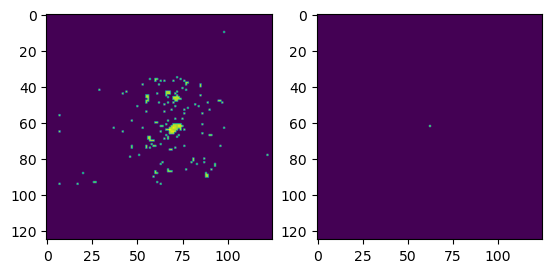

In [17]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img1[0]*(256))
ax[1].imshow(img2[0]*(256))
plt.show()

# plt.savefig('Report/Figures/Gluon_reconstructed.pdf')

## Dataset generation

In [25]:
f = h5.File("quark-gluon_data-set_n139306.hdf5")
print(f['X_jets'].shape)
f.close()

(139306, 125, 125, 3)


In [3]:
from data_load import preprocess

In [3]:
with h5.File('quark_jets_ecal.h5', 'w') as g:
    f = h5.File('quark-gluon_data-set_n139306.hdf5', 'r')
    
    dset = g.create_dataset('x', shape=(0, 125, 125, 3), dtype=np.float32,
                            maxshape=(None, 125, 125, 3))
    L = 100_000
    w = 10_000

    for i in range(10):
        x, y = f['X_jets'][i*w: (i+1)*w], f['y'][i*w: (i+1)*w]
        x, y = torch.from_numpy(x), torch.from_numpy(y)
        (ind_0,) = torch.nonzero(y==0, as_tuple=True)
        x = x[ind_0]
        curr_shape = dset.shape[0]
        dset.resize((curr_shape+x.shape[0], 125, 125, 3))
        dset[curr_shape:, :, :] = x
    print(dset.shape[0])
    f.close()

50000


In [20]:
x = torch.FloatTensor(
    [1e-3, 0., 0.1, 1.2]
)
x2 = torch.nan_to_num(x.log(), neginf=0.)
x2

tensor([-6.9078,  0.0000, -2.3026,  0.1823])

In [12]:
with h5.File('gluon_jets_ecal.h5', 'w') as g:
    f = h5.File('quark-gluon_data-set_n139306.hdf5', 'r')
    
    dset = g.create_dataset('x', shape=(0, 125, 125, 3), dtype=np.float32,
                            maxshape=(None, 125, 125, 3))
    L = 100_000
    w = 10_000

    for i in range(10):
        x, y = f['X_jets'][i*w: (i+1)*w], f['y'][i*w: (i+1)*w]
        x, y = torch.from_numpy(x), torch.from_numpy(y)
        (ind_0,) = torch.nonzero(y==1, as_tuple=True)
        x = x[ind_0]
        curr_shape = dset.shape[0]
        dset.resize((curr_shape+x.shape[0], 125, 125, 3))
        dset[curr_shape:, :, :] = x
    print(dset.shape[0])
    f.close()

50000


This generates a 3-channel heavy-duty dataset

In [2]:
# with h5.File('quark_jets_ecal.h5') as g:
#     with h5.File('quark_3chan_graph.h5', 'w') as h:
#         X_dset = h.create_dataset('X', shape=(0, 1000, 4), dtype=np.float32,
#                             maxshape=(None, 1000, 4))
#         A_dset = h.create_dataset('A', shape=(0, 1000, 1000), dtype=np.float32,
#                             maxshape=(None, 1000, 1000))
#         mask_dset = h.create_dataset('mask', shape=(0, 1000), dtype=np.float32,
#                             maxshape=(None, 1000))
        
#         device = torch.device("cpu")
#         w = 2000
#         for i in range(25):
#             x = g['x'][i*w: (i+1)*w]
#             x = torch.from_numpy(x).to(device)
#             X, A, mask, _ = preprocess(x, device)
            
#             curr_shape = X_dset.shape[0]
                
#             X_dset.resize((curr_shape+w, 1000, 4))
#             A_dset.resize((curr_shape+w, 1000, 1000))
#             mask_dset.resize((curr_shape+w, 1000))
            
#             X_dset[curr_shape:, :, :] = X.to("cpu").numpy()
#             A_dset[curr_shape:, :, :] = A.to("cpu").numpy()
#             mask_dset[curr_shape:, :] = mask.to("cpu").numpy()

This generates a smaller single channel dataset

In [3]:
with h5.File('quark_jets_ecal.h5') as g:
    with h5.File('quark_ecal_graph.h5', 'w') as h:
        X_dset = h.create_dataset('X', shape=(0, 400, 3), dtype=np.float32,
                            maxshape=(None, 400, 3), compression="gzip")
        NL_dset = h.create_dataset('NL', shape=(0, 400, 6), dtype=np.float32,
                            maxshape=(None, 400, 6), compression="gzip")
        mask_dset = h.create_dataset('mask', shape=(0, 400), dtype=np.float32,
                            maxshape=(None, 400), compression="gzip")
        
        device = "cpu"
        w = 2000
        for i in range(25):
            x = g['x'][i*w: (i+1)*w]
            x[x < 1e-3] = 0
            x = torch.from_numpy(x)[:, :, :, 1].to(device)
            X, A, mask, _ = preprocess(x, device)
            
            NL = torch.argsort(A, 1, True)[:, :6, :].int().permute(0, 2, 1)
            
            curr_shape = X_dset.shape[0]
            X_dset.resize((curr_shape+w, 400, 3))
            NL_dset.resize((curr_shape+w, 400, 6))
            mask_dset.resize((curr_shape+w, 400))
            
            X_dset[curr_shape:, :, :] = X.to("cpu").numpy()
            NL_dset[curr_shape:, :, :] = NL.to("cpu").numpy()
            mask_dset[curr_shape:, :] = mask.float().to("cpu").numpy()
            

torch.bool tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.bool tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.bool tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.bool tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0., 

In [18]:
# Check minimum and maximum energies
with h5.File('quark_ecal_graph.h5') as g:
    device = "cpu"
    w = 10_000
    for i in range(5):
        X = g['X'][i*w: (i+1)*w]
        mask = torch.from_numpy(g['mask'][i*w: (i+1)*w])
        counts = mask.sum(1)
        # Studying the typical energies
        E_hit = torch.from_numpy(X[:, :, 2])
        log_E_hit = torch.nan_to_num(torch.log(E_hit), neginf=0.)
        
        print("Mean E: ", log_E_hit.mean(), 
              "Std E: ", (log_E_hit.std(1)*(20/(counts**0.5))).mean())

Mean E:  tensor(-1.9866) Std E:  tensor(4.8814)
Mean E:  tensor(-1.9837) Std E:  tensor(4.8877)
Mean E:  tensor(-2.0412) Std E:  tensor(4.8623)
Mean E:  tensor(-2.0492) Std E:  tensor(4.8592)
Mean E:  tensor(-2.2505) Std E:  tensor(4.7457)


In [13]:
print(0.5*(np.log(1.4) + np.log(1e-3)))
print(0.5*(np.log(1.4) - np.log(1e-3)))

-3.285641521180462
3.622113757801675


In [6]:
with h5.File('quark_ecal_graph.h5') as g:
    with h5.File('quark_ecal_graph_normalized.h5', 'w') as h:
        X_dset = h.create_dataset('X', shape=(0, 400, 3), dtype=np.float32,
                            maxshape=(None, 400, 3), compression="gzip")
        NL_dset = h.create_dataset('NL', shape=(0, 400, 6), dtype=np.float32,
                            maxshape=(None, 400, 6), compression="gzip")
        mask_dset = h.create_dataset('mask', shape=(0, 400), dtype=np.float32,
                            maxshape=(None, 400), compression="gzip")
        
        device = "cpu"
        w = 2000
        for i in range(25):
            X = g['X'][i*w: (i+1)*w]
            NL = g['NL'][i*w: (i+1)*w]
            mask = g['mask'][i*w: (i+1)*w]
            
            X = torch.from_numpy(X)            
            X[:, :, :2] = X[:, :, :2]/62.5 - 1 # Pixels in (-1, 1) range
            X[:, :, 2] = (torch.nan_to_num(X[:, :, 2].log(), neginf=0.) + 2)/4.8 
            # Energies in (-1, 1)
            
            curr_shape = X_dset.shape[0]
            
            X_dset.resize((curr_shape+w, 400, 3))
            NL_dset.resize((curr_shape+w, 400, 6))
            mask_dset.resize((curr_shape+w, 400))
            
            X_dset[curr_shape:, :, :] = X.to("cpu").numpy()
            NL_dset[curr_shape:, :, :] = NL
            mask_dset[curr_shape:, :] = mask
            

In [2]:
dataset = get_train_dataset()